In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [42]:
x_cols = ['Loan_age', 'CreditScore',
       'FullDocumentation', 'State_CA', 'State_FL', 'State_NY', 'State_NJ',
       'State_GA', 'Spread', 'Spread_squared', 'Remaining_balance', 'LTV',
       'spring_summer']
indicator_cols = ['Default_indicator', 'Prepayment_indicator']
y_cols = ['status']

In [43]:
loans_df = pd.read_csv('notebooks/FRM_perf.csv')
is_active = loans_df[['Default_indicator', 'Prepayment_indicator']].sum(axis=1) == 0
loans_df['status'] = loans_df[indicator_cols].assign(Active=is_active.astype(int)).idxmax(axis=1).str.replace('_indicator', '').astype('category')

train_loan_id, test_loan_id = train_test_split(loans_df['Loan_id'].unique(), test_size=0.1, random_state=0)
train_loans = loans_df.loc[loans_df['Loan_id'].isin(train_loan_id)]
test_loans = loans_df.loc[loans_df['Loan_id'].isin(test_loan_id)]

In [135]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from imblearn.over_sampling import ADASYN, RandomOverSampler


In [146]:
clf = RandomForestClassifier(max_depth=5)
X_resampled, y_resampled = RandomOverSampler().fit_resample(train_loans[x_cols], train_loans[y_cols])
clf.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=5)

In [147]:
calc_auc = lambda df: roc_auc_score(df[y_cols].squeeze(), clf.predict_proba(df[x_cols]), multi_class='ovr')
calc_auc(train_loans), calc_auc(test_loans)

(0.8862000825139068, 0.8241953668296809)

In [130]:
calc_avg_prob = lambda df: pd.DataFrame(clf.predict_proba(df[x_cols]), columns=df['status'].cat.categories).assign(status=df[y_cols].values).pivot_table(index='status')
calc_avg_prob(train_loans), calc_avg_prob(test_loans)

(              Active   Default  Prepayment
 status                                    
 Active      0.519284  0.385942    0.094774
 Default     0.385848  0.528077    0.086074
 Prepayment  0.094858  0.084912    0.820230,
               Active   Default  Prepayment
 status                                    
 Active      0.504612  0.401509    0.093878
 Default     0.405512  0.470624    0.123865
 Prepayment  0.101062  0.117407    0.781530)

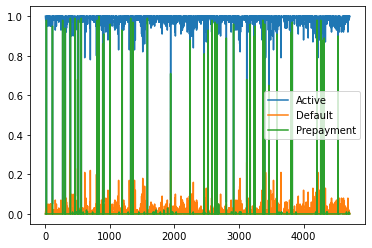

In [64]:
pd.DataFrame(clf.predict_proba(test_loans[x_cols]), columns=loans_df['status'].cat.categories).plot()

In [113]:
y_resampled['status'].value_counts()

Prepayment    43847
Default       43847
Active        43847
Name: status, dtype: int64

In [114]:
train_loans[y_cols]['status'].value_counts()

Active        43847
Default         403
Prepayment      309
Name: status, dtype: int64